# Linear model on features extracted from power 2011 connectomes



In [1]:
path = ".."

import os
import sys
sys.path.insert(0, path)

import numpy as np
import pandas as pd

import matplotlib
matplotlib.use('Agg')
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns

In [2]:
from problem import get_train_data, get_test_data

data_train_, labels_train_ = get_train_data(path=path)
data_test_, labels_test_ = get_test_data(path=path)

data_train = pd.concat([data_train_, pd.Series(labels_train_, index=data_train_.index, name='target')], axis=1)

accepted_fmri = data_train['fmri_select'] > 0

In [3]:
len([c for c in data_train_.columns if "anatomy" in c])

208

In [4]:
data_train['fmri_select'].value_counts()

1    1007
0     120
Name: fmri_select, dtype: int64

In [5]:
fmri_cols = [c for c in data_train_.columns if "fmri" in c]
fmri_cols

['fmri_basc064',
 'fmri_basc122',
 'fmri_basc197',
 'fmri_craddock_scorr_mean',
 'fmri_harvard_oxford_cort_prob_2mm',
 'fmri_motions',
 'fmri_msdl',
 'fmri_power_2011',
 'fmri_select']

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit


def evaluation(X, y, verbose=False):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.65, random_state=42).split(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=verbose, return_train_score=True,
                             n_jobs=1)
    
    return results



from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score
seed = 12


def evaluation_with_test(X, y, X_test, y_test, verbose=False):
    
    n_splits = 7
    splt = StratifiedKFold(n_splits=n_splits, random_state=seed)
    
    results = {}
    validation_roc_folds = []
    test_roc_folds = []    
    y_test_probas_foldes = []
    for train_indices, test_indices in splt.split(X, y):

        train_idx = X.index[train_indices]
        test_idx = X.index[test_indices]
        X_train = X.loc[train_idx, :]
        y_train = y[train_indices]

        pipe = make_pipeline(FeatureExtractor(), Classifier())
        pipe.fit(X_train, y_train)

        X_valid = X.loc[test_idx, :]
        y_valid = y[test_indices]
        y_valid_pred = pipe.predict(X_valid)
        val_roc = roc_auc_score(y_valid, y_valid_pred)
#         print("ROC valid={}".format(val_roc))
        validation_roc_folds.append(val_roc)
        
        y_test_probas = pipe.predict_proba(X_test)[:, 1]
        y_test_pred = (y_test_probas > 0.5).astype(np.uint8)
        y_test_probas_foldes.append(y_test_probas)
        test_roc = roc_auc_score(y_test, y_test_pred)
#         print("ROC test={}".format(test_roc))
        test_roc_folds.append(test_roc)

    y_test_pred = (np.mean(y_test_probas_foldes, axis=0) > 0.5).astype(np.uint8)
    bag_test_roc = roc_auc_score(y_test, y_test_pred)
#     print("ROC test={}".format(bag_test_roc))
    
    mean_validation_roc = np.mean(validation_roc_folds)
    mean_test_roc = np.mean(test_roc_folds)
    
    results['mean_validation_roc'] = mean_validation_roc
    results['mean_test_roc'] = mean_test_roc    
    return results



from problem import get_cv


def original_evaluation(X, y, verbose=False):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = get_cv(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=verbose, return_train_score=True,
                             n_jobs=1)    
    return results

### Atlas Power 2011

In [9]:
from nilearn import plotting

In [7]:
from nilearn import datasets
atlas = datasets.fetch_coords_power_2011()

In [8]:
from nilearn.signal import clean
from nilearn.connectome import ConnectivityMeasure


correlation_measure = ConnectivityMeasure(kind='covariance', discard_diagonal=True, vectorize=False)

In [7]:
data1_train = data_train.loc[accepted_fmri, :].copy()

In [8]:
x_train = np.zeros((len(data1_train), 264, 264))

In [13]:
ll = len(data1_train.index)
for i, idx in enumerate(data1_train.index):
    if i % 100 == 0:
        print("-- {}/{}".format(i, ll))
    path_motions = os.path.join(path, data1_train.loc[idx, 'fmri_motions'])
    confounds = np.loadtxt(path_motions)
    path_fmri_atlas = os.path.join(path, data1_train.loc[idx, 'fmri_power_2011'])
    timeseries = pd.read_csv(path_fmri_atlas, header=None).values
    cleaned_timeseries = clean(timeseries, confounds=confounds)
    correlation_matrix = correlation_measure.fit_transform([cleaned_timeseries])[0]
    x_train[i, :, :] = correlation_matrix    
    

Compare connectomes by age, gender

In [ ]:
data1_train.loc[:, 'index'] = np.arange(len(data1_train))

In [ ]:
data1_train['participants_sex'].value_counts().sort_index()

In [13]:
index_females = data1_train[(data1_train['participants_sex'] == "F")]['index']
index_males = data1_train[(data1_train['participants_sex'] == "M")]['index']

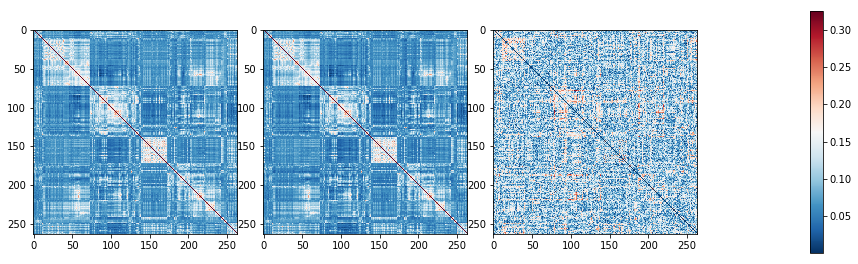

In [47]:
mean_female_connectome = x_train[index_females, :, :].mean(axis=0)
mean_male_connectome = x_train[index_males, :, :].mean(axis=0)

fig = plt.figure(figsize=(12, 12))
plt.subplot(131)
plotting.plot_matrix(mean_female_connectome, labels=None, colorbar=True, figure=fig)
plt.subplot(132)
plotting.plot_matrix(mean_male_connectome, labels=None, colorbar=True, figure=fig)
plt.subplot(133)
plotting.plot_matrix(np.sqrt(np.abs(mean_female_connectome - mean_male_connectome)), labels=None, colorbar=True, figure=fig)



/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


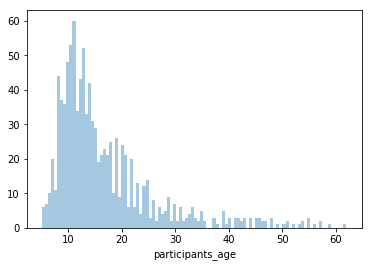

In [49]:
sns.distplot(data1_train['participants_age'], kde=False, bins=100)

In [14]:
index_small_children = data1_train[(data1_train['participants_age'] < 7)]['index']
index_teens = data1_train[(data1_train['participants_age'] >= 7) & (data1_train['participants_age'] < 18)]['index']
index_adults = data1_train[(data1_train['participants_age'] >= 18) & (data1_train['participants_age'] < 40)]['index']
index_older_adults = data1_train[(data1_train['participants_age'] >= 40)]['index']

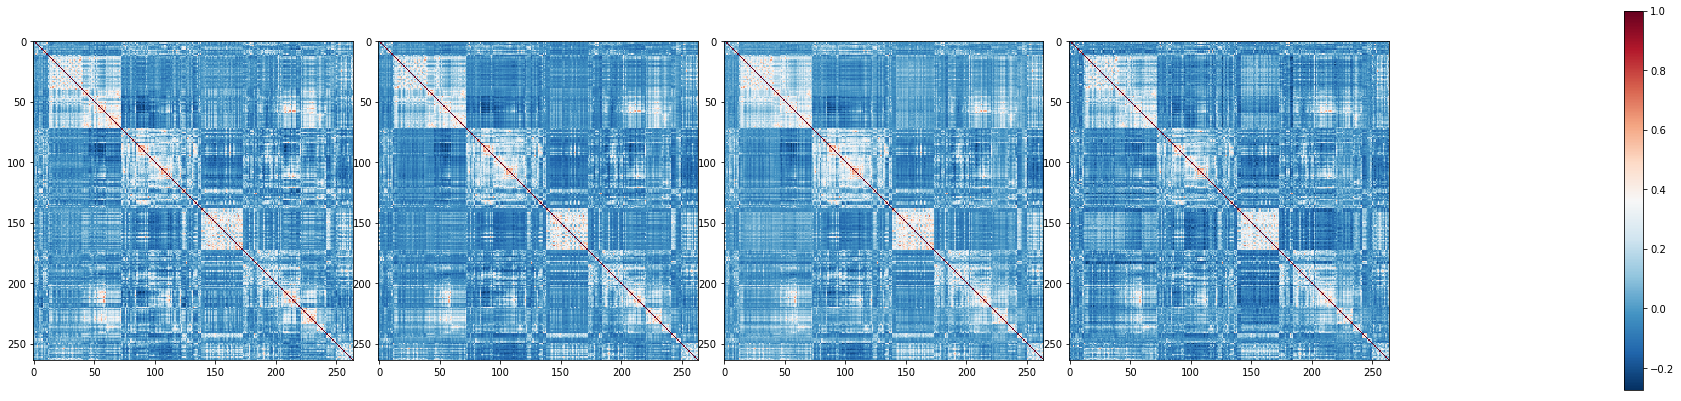

In [17]:
mean_small_children_connectome = x_train[index_small_children, :, :].mean(axis=0)
mean_teens_connectome = x_train[index_teens, :, :].mean(axis=0)
mean_adults_connectome = x_train[index_adults, :, :].mean(axis=0)
mean_older_adults_connectome = x_train[index_older_adults, :, :].mean(axis=0)

fig = plt.figure(figsize=(24, 12))
plt.subplot(141)
plotting.plot_matrix(mean_small_children_connectome, labels=None, colorbar=True, figure=fig)
plt.subplot(142)
plotting.plot_matrix(mean_teens_connectome, labels=None, colorbar=True, figure=fig)
plt.subplot(143)
plotting.plot_matrix(mean_adults_connectome, labels=None, colorbar=True, figure=fig)
plt.subplot(144)
plotting.plot_matrix(mean_older_adults_connectome, labels=None, colorbar=True, figure=fig)



Select features with LR

In [9]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(20, 10))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    if feature_names is not None:
        feature_names = np.array(feature_names)
        plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

In [10]:
from nilearn.signal import clean
from nilearn.connectome import ConnectivityMeasure


data1_train = data_train.loc[accepted_fmri, :].copy()
correlation_measure = ConnectivityMeasure(kind='covariance', discard_diagonal=True, vectorize=True)

In [11]:
x_train = np.zeros((len(data1_train), 34716))

ll = len(data1_train.index)
for i, idx in enumerate(data1_train.index):
    if i % 100 == 0:
        print("-- {}/{}".format(i, ll))
    path_motions = os.path.join(path, data1_train.loc[idx, 'fmri_motions'])
    confounds = np.loadtxt(path_motions)
    path_fmri_atlas = os.path.join(path, data1_train.loc[idx, 'fmri_power_2011'])
    timeseries = pd.read_csv(path_fmri_atlas, header=None).values
    cleaned_timeseries = clean(timeseries, confounds=confounds)
    correlation_matrix = correlation_measure.fit_transform([cleaned_timeseries])[0]
    x_train[i, :] = correlation_matrix    
    

-- 0/1007
-- 100/1007
-- 200/1007
-- 300/1007
-- 400/1007
-- 500/1007
-- 600/1007
-- 700/1007
-- 800/1007
-- 900/1007
-- 1000/1007


In [12]:
data2_train = data1_train[['participants_sex', 'participants_age', 'target']].copy()
data2_train['participants_sex'] = data2_train['participants_sex'].map({'F': -1.0, 'M': +1.0})

In [13]:
power_features = ["power_{}".format(i) for i in range(x_train.shape[1])]
data2_train = pd.concat([data2_train, pd.DataFrame(x_train, index=data2_train.index, columns=power_features)], axis=1)

In [14]:
x_test = np.zeros((len(data_test_), 34716))

ll = len(data_test_.index)
for i, idx in enumerate(data_test_.index):
    if i % 100 == 0:
        print("-- {}/{}".format(i, ll))
    path_motions = os.path.join(path, data_test_.loc[idx, 'fmri_motions'])
    confounds = np.loadtxt(path_motions)
    path_fmri_atlas = os.path.join(path, data_test_.loc[idx, 'fmri_power_2011'])
    timeseries = pd.read_csv(path_fmri_atlas, header=None).values
    cleaned_timeseries = clean(timeseries, confounds=confounds)
    correlation_matrix = correlation_measure.fit_transform([cleaned_timeseries])[0]
    x_test[i, :] = correlation_matrix

-- 0/23


In [15]:
data2_test = data_test_[['participants_sex', 'participants_age']].copy()
data2_test['participants_sex'] = data2_test['participants_sex'].map({'F': -1.0, 'M': +1.0})
data2_test = pd.concat([data2_test, pd.DataFrame(x_test, index=data2_test.index, columns=power_features)], axis=1)

In [16]:
data_ = np.zeros((len(x_train), len(power_features) * 2))
new_columns = []

for i, name in enumerate(power_features):
    new_col = "{} x participants_age".format(name)
    new_columns.append(new_col)
    data_[:, 2*i] = data2_train[name] * data2_train['participants_age']
    new_col = "{} / participants_age".format(name)
    new_columns.append(new_col)
    data_[:, 2*i + 1] = data2_train[name] / data2_train['participants_age']
    

pairs_df = pd.DataFrame(data_, columns=new_columns, index=data2_train.index)
data2_train = pd.concat([data2_train, pairs_df], axis=1)

Only fMRI

In [18]:
cols = new_columns

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


n_jobs=1
seed = 42
        
# log_reg = LogisticRegression(random_state=seed)
ridge = RidgeClassifier(random_state=seed)

# pipe = make_pipeline(StandardScaler(), log_reg)
pipe = make_pipeline(StandardScaler(), ridge)
pipe.fit(data2_train[cols], data2_train['target'])

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridgeclassifier', RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=42, solver='auto',
        tol=0.001))])

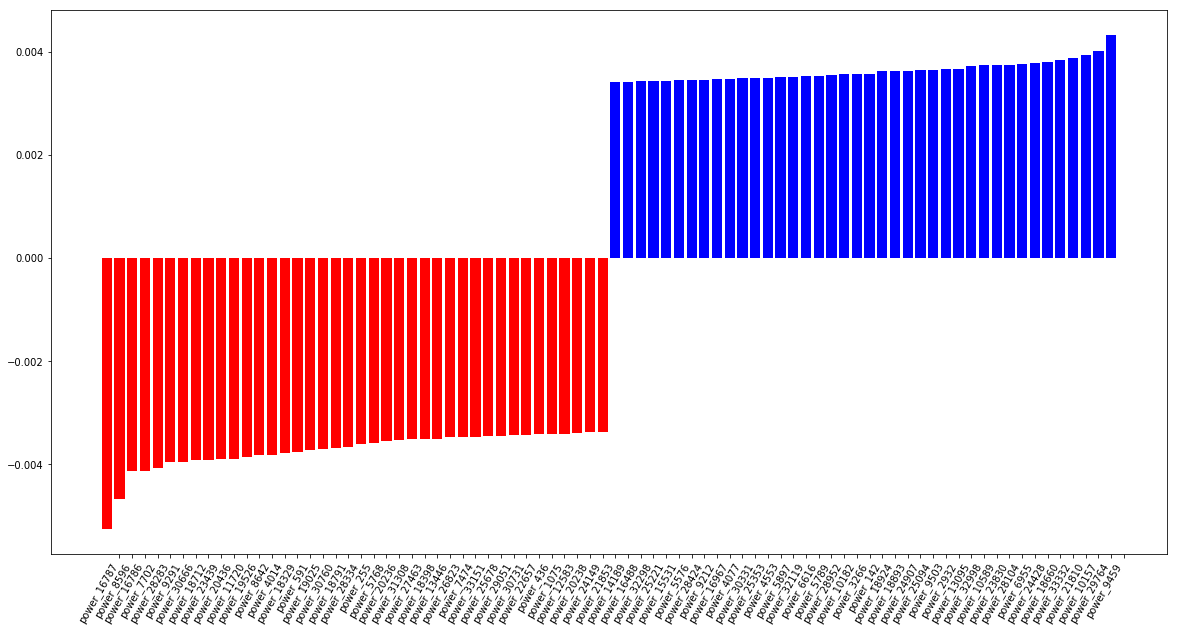

In [51]:
# visualize_coefficients(log_reg, feature_names=cols, n_top_features=40)
visualize_coefficients(ridge, feature_names=cols, n_top_features=40)

In [53]:
# coef = log_reg.coef_.ravel()
coef = ridge.coef_.ravel()

coef.min(), coef.max(), np.abs(coef).min(), len(coef)

(-0.005259474955975915, 0.004325174324393052, 3.3542405230848834e-08, 34716)

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


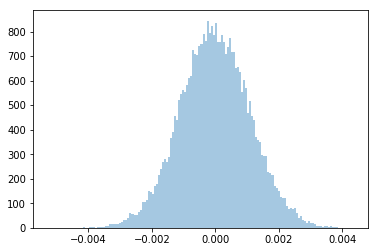

In [54]:
sns.distplot(coef, kde=False, bins=150)

In [55]:
from itertools import product

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold


seed = 90
       

class FeatureExtractor(BaseEstimator, TransformerMixin):
        
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        return X_df
    

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(
                                StandardScaler(),
                                LogisticRegressionCV(n_jobs=8,
                                                     # cv=StratifiedKFold(n_splits=5, random_state=seed),                                                    
                                                     scoring="roc_auc", 
                                                     random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(
                                 StandardScaler(),
                                 LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

Grid search



In [56]:
# neg_thresholds = np.linspace(-0.02, -0.03, 30)
# pos_thresholds = np.linspace(0.02, 0.03, 30)

neg_thresholds = np.linspace(-0.001, -0.0034, 30)
pos_thresholds = np.linspace(0.001, 0.0034, 30)

max_features = 450

In [57]:
mode_eval_with_test = False

In [ ]:
best_roc = 0.0
best_thresholds = None
max_early_stopping = 100
c = max_early_stopping

for i, (neg_threshold, pos_threshold) in enumerate(product(neg_thresholds, pos_thresholds)):
    print("Trial: ", i, neg_threshold, pos_threshold, end=" | ")
    positive_coefficients = np.where(coef > pos_threshold)[0]
    negative_coefficients = np.where(coef < neg_threshold)[0]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    top_1_selected_columns = np.array(cols)[interesting_coefficients].tolist()
    
    print("{} | ".format(len(top_1_selected_columns)), end=" -> ")
    
    if max_features is not None and len(top_1_selected_columns) > max_features:
        print("NA")
        continue
    
    if not mode_eval_with_test:
        results = evaluation(data2_train.loc[:, top_1_selected_columns], data2_train.loc[:, 'target'], verbose=False)    
        current_roc = np.mean(results['test_roc_auc'])
        print(current_roc)
    else:
        results = evaluation_with_test(data2_train.loc[:, top_1_selected_columns], 
                                       data2_train.loc[:, 'target'].values, 
                                       data2_test.loc[:, top_1_selected_columns], 
                                       labels_test_)
        current_roc = 1.0 / (results['mean_validation_roc'] - results['mean_test_roc'] + 1e-10)
        print(results['mean_validation_roc'], results['mean_test_roc'])        
        
    c -= 1
    if current_roc > best_roc:
        best_thresholds = (neg_threshold, pos_threshold)
        best_roc = current_roc
        c = max_early_stopping

    if c == 0:
        print("Stop by early stopping")
        break

Trial:  0 -0.001 0.001 | 12524 |  -> NA
Trial:  1 -0.001 0.0010827586206896551 | 11920 |  -> NA
Trial:  2 -0.001 0.0011655172413793102 | 11281 |  -> NA
Trial:  3 -0.001 0.0012482758620689656 | 10693 |  -> NA
Trial:  4 -0.001 0.0013310344827586207 | 10207 |  -> NA
Trial:  5 -0.001 0.0014137931034482758 | 9746 |  -> NA
Trial:  6 -0.001 0.001496551724137931 | 9332 |  -> NA
Trial:  7 -0.001 0.0015793103448275862 | 8953 |  -> NA
Trial:  8 -0.001 0.0016620689655172413 | 8599 |  -> NA
Trial:  9 -0.001 0.0017448275862068964 | 8302 |  -> NA
Trial:  10 -0.001 0.0018275862068965515 | 8013 |  -> NA
Trial:  11 -0.001 0.0019103448275862068 | 7798 |  -> NA
Trial:  12 -0.001 0.001993103448275862 | 7586 |  -> NA
Trial:  13 -0.001 0.002075862068965517 | 7410 |  -> NA
Trial:  14 -0.001 0.0021586206896551724 | 7259 |  -> NA
Trial:  15 -0.001 0.0022413793103448275 | 7114 |  -> NA
Trial:  16 -0.001 0.0023241379310344826 | 7005 |  -> NA
Trial:  17 -0.001 0.0024068965517241377 | 6903 |  -> NA
Trial:  18 -0.00

Trial:  125 -0.0013310344827586207 0.0014137931034482758 | 7228 |  -> NA
Trial:  126 -0.0013310344827586207 0.001496551724137931 | 6814 |  -> NA
Trial:  127 -0.0013310344827586207 0.0015793103448275862 | 6435 |  -> NA
Trial:  128 -0.0013310344827586207 0.0016620689655172413 | 6081 |  -> NA
Trial:  129 -0.0013310344827586207 0.0017448275862068964 | 5784 |  -> NA
Trial:  130 -0.0013310344827586207 0.0018275862068965515 | 5495 |  -> NA
Trial:  131 -0.0013310344827586207 0.0019103448275862068 | 5280 |  -> NA
Trial:  132 -0.0013310344827586207 0.001993103448275862 | 5068 |  -> NA
Trial:  133 -0.0013310344827586207 0.002075862068965517 | 4892 |  -> NA
Trial:  134 -0.0013310344827586207 0.0021586206896551724 | 4741 |  -> NA
Trial:  135 -0.0013310344827586207 0.0022413793103448275 | 4596 |  -> NA
Trial:  136 -0.0013310344827586207 0.0023241379310344826 | 4487 |  -> NA
Trial:  137 -0.0013310344827586207 0.0024068965517241377 | 4385 |  -> NA
Trial:  138 -0.0013310344827586207 0.00248965517241379

Trial:  301 -0.0018275862068965515 0.0010827586206896551 | 7234 |  -> NA
Trial:  302 -0.0018275862068965515 0.0011655172413793102 | 6595 |  -> NA
Trial:  303 -0.0018275862068965515 0.0012482758620689656 | 6007 |  -> NA
Trial:  304 -0.0018275862068965515 0.0013310344827586207 | 5521 |  -> NA
Trial:  305 -0.0018275862068965515 0.0014137931034482758 | 5060 |  -> NA
Trial:  306 -0.0018275862068965515 0.001496551724137931 | 4646 |  -> NA
Trial:  307 -0.0018275862068965515 0.0015793103448275862 | 4267 |  -> NA
Trial:  308 -0.0018275862068965515 0.0016620689655172413 | 3913 |  -> NA
Trial:  309 -0.0018275862068965515 0.0017448275862068964 | 3616 |  -> NA
Trial:  310 -0.0018275862068965515 0.0018275862068965515 | 3327 |  -> NA
Trial:  311 -0.0018275862068965515 0.0019103448275862068 | 3112 |  -> NA
Trial:  312 -0.0018275862068965515 0.001993103448275862 | 2900 |  -> NA
Trial:  313 -0.0018275862068965515 0.002075862068965517 | 2724 |  -> NA
Trial:  314 -0.0018275862068965515 0.00215862068965517

Trial:  487 -0.0023241379310344826 0.0015793103448275862 | 3209 |  -> NA
Trial:  488 -0.0023241379310344826 0.0016620689655172413 | 2855 |  -> NA
Trial:  489 -0.0023241379310344826 0.0017448275862068964 | 2558 |  -> NA
Trial:  490 -0.0023241379310344826 0.0018275862068965515 | 2269 |  -> NA
Trial:  491 -0.0023241379310344826 0.0019103448275862068 | 2054 |  -> NA
Trial:  492 -0.0023241379310344826 0.001993103448275862 | 1842 |  -> NA
Trial:  493 -0.0023241379310344826 0.002075862068965517 | 1666 |  -> NA
Trial:  494 -0.0023241379310344826 0.0021586206896551724 | 1515 |  -> NA
Trial:  495 -0.0023241379310344826 0.0022413793103448275 | 1370 |  -> NA
Trial:  496 -0.0023241379310344826 0.0023241379310344826 | 1261 |  -> NA
Trial:  497 -0.0023241379310344826 0.0024068965517241377 | 1159 |  -> NA
Trial:  498 -0.0023241379310344826 0.002489655172413793 | 1064 |  -> NA
Trial:  499 -0.0023241379310344826 0.0025724137931034483 | 961 |  -> NA
Trial:  500 -0.0023241379310344826 0.002655172413793103

Trial:  624 -0.002655172413793103 0.002986206896551724 | 441 |  -> 0.9428318799356262
Trial:  625 -0.002655172413793103 0.003068965517241379 | 415 |  -> 0.9342303229911298
Trial:  626 -0.002655172413793103 0.003151724137931034 | 391 |  -> 0.9164620681911748
Trial:  627 -0.002655172413793103 0.003234482758620689 | 380 |  -> 0.9117294808937461
Trial:  628 -0.002655172413793103 0.0033172413793103447 | 367 |  -> 0.9085248325161871
Trial:  629 -0.002655172413793103 0.0034 | 359 |  -> 0.9048504809311726
Trial:  630 -0.0027379310344827585 0.001 | 6405 |  -> NA
Trial:  631 -0.0027379310344827585 0.0010827586206896551 | 5801 |  -> NA
Trial:  632 -0.0027379310344827585 0.0011655172413793102 | 5162 |  -> NA
Trial:  633 -0.0027379310344827585 0.0012482758620689656 | 4574 |  -> NA
Trial:  634 -0.0027379310344827585 0.0013310344827586207 | 4088 |  -> NA
Trial:  635 -0.0027379310344827585 0.0014137931034482758 | 3627 |  -> NA
Trial:  636 -0.0027379310344827585 0.001496551724137931 | 3213 |  -> NA
Tri

Trial:  740 -0.002986206896551724 0.002655172413793103 | 409 |  -> 0.9504247913469814
Trial:  741 -0.002986206896551724 0.0027379310344827585 | 351 |  -> 0.9423752760208093
Trial:  742 -0.002986206896551724 0.0028206896551724136 | 314 |  -> 0.934985403645346
Trial:  743 -0.002986206896551724 0.0029034482758620687 | 284 |  -> 0.9277658220741793
Trial:  744 -0.002986206896551724 0.002986206896551724 | 250 |  -> 0.9248596504360194
Trial:  745 -0.002986206896551724 0.003068965517241379 | 224 |  -> 0.9174903626632733
Trial:  746 -0.002986206896551724 0.003151724137931034 | 200 |  -> 0.894461806205322
Trial:  747 -0.002986206896551724 0.003234482758620689 | 189 |  -> 0.8931649762341405
Trial:  748 -0.002986206896551724 0.0033172413793103447 | 176 |  -> 0.8889105131180062
Trial:  749 -0.002986206896551724 0.0034 | 168 |  -> 0.8845849395561212
Trial:  750 -0.003068965517241379 0.001 | 6266 |  -> NA
Trial:  751 -0.003068965517241379 0.0010827586206896551 | 5662 |  -> NA
Trial:  752 -0.003068965

Trial:  859 -0.0033172413793103447 0.0025724137931034483 | 390 |  -> 0.9215651783375126
Trial:  860 -0.0033172413793103447 0.002655172413793103 | 334 |  -> 0.9156751749691232
Trial:  861 -0.0033172413793103447 0.0027379310344827585 | 276 |  -> 0.9063082450690519
Trial:  862 -0.0033172413793103447 0.0028206896551724136 | 239 |  -> 0.8984308918746958
Trial:  863 -0.0033172413793103447 0.0029034482758620687 | 209 |  -> 0.8907678056813504
Trial:  864 -0.0033172413793103447 0.002986206896551724 | 175 |  -> 0.8853568621580148
Trial:  865 -0.0033172413793103447 0.003068965517241379 | 149 |  -> 0.8829493993038662
Trial:  866 -0.0033172413793103447 0.003151724137931034 | 125 |  -> 0.8572270668812456
Trial:  867 -0.0033172413793103447 0.003234482758620689 | 114 |  -> 0.854085107975598
Trial:  868 -0.0033172413793103447 0.0033172413793103447 | 101 |  -> 0.8470433025188069
Trial:  869 -0.0033172413793103447 0.0034 | 93 |  -> 0.8383341442419253
Trial:  870 -0.0034 0.001 | 6193 |  -> NA
Trial:  871 

In [45]:
# best_thresholds = (-0.0082, 0.0088)
# best_thresholds = (-0.011, 0.011)
# best_thresholds = (-0.010333333333333333, 0.011666666666666665)
# best_thresholds = (-0.02103448275862069, 0.029310344827586206)
best_thresholds

(-0.02103448275862069, 0.029310344827586206)

In [48]:
# neg_threshold = 0.27 * coef.min()
# pos_threshold = 0.127 * coef.max()
neg_threshold, pos_threshold = best_thresholds
print(neg_threshold, pos_threshold)

positive_coefficients = np.where(coef > pos_threshold)[0]
negative_coefficients = np.where(coef < neg_threshold)[0]

print(len(positive_coefficients), len(negative_coefficients), len(coef))

interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
top_1_selected_columns = np.array(cols)[interesting_coefficients].tolist()

        
if not mode_eval_with_test:
    results = evaluation(data2_train.loc[:, top_1_selected_columns], data2_train.loc[:, 'target'], verbose=True)

    print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                            np.std(results['train_roc_auc'])))
    print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                              np.std(results['test_roc_auc'])))

    print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                             np.std(results['train_accuracy'])))
    print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                               np.std(results['test_accuracy'])))
else:
    results = evaluation_with_test(data2_train.loc[:, top_1_selected_columns], 
                               data2_train.loc[:, 'target'].values, 
                               data2_test.loc[:, top_1_selected_columns], 
                               labels_test_)
    print("Mean validation ROC-AUC vs Mean test ROC-AUC : ")
    print(results['mean_validation_roc'], results['mean_test_roc'])        

-0.02103448275862069 0.029310344827586206
5 239 34716
Mean validation ROC-AUC vs Mean test ROC-AUC : 
0.8333034920745417 0.6158008658008658






Only power features:
```
-0.015222222222222222 0.015222222222222222
1263 1259 34716
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.997 +- 0.001 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.974 +- 0.005
```

< 500 features
```
-0.02010344827586207 0.021551724137931036
183 309 34716
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.971 +- 0.006 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.913 +- 0.012
```

Power features `x,/` participants_age
```
-0.011 0.011
833 895 69432
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.996 +- 0.002 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.973 +- 0.007
```

In [41]:
results = original_evaluation(data2_train.loc[:, top_1_selected_columns], data2_train.loc[:, 'target'], verbose=False)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.985 +- 0.007 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.954 +- 0.012


In [40]:
print("[", end="")
for f in top_1_selected_columns:
    print("\"{}\"".format(f), end=", ")
print("]")

["power_46", "power_62", "power_255", "power_436", "power_499", "power_591", "power_648", "power_789", "power_1075", "power_1204", "power_1231", "power_1265", "power_1302", "power_1349", "power_1431", "power_2347", "power_2726", "power_2840", "power_2897", "power_2898", "power_2945", "power_2951", "power_2958", "power_2962", "power_3028", "power_3297", "power_3448", "power_3576", "power_3679", "power_3730", "power_3853", "power_3901", "power_3940", "power_4014", "power_4335", "power_4336", "power_4380", "power_4395", "power_4499", "power_4637", "power_4712", "power_5106", "power_5121", "power_5690", "power_5696", "power_5703", "power_5768", "power_5917", "power_5946", "power_6076", "power_6112", "power_6186", "power_6297", "power_6435", "power_6630", "power_6658", "power_6664", "power_6693", "power_6710", "power_6812", "power_6816", "power_6915", "power_6976", "power_7205", "power_7285", "power_7332", "power_7382", "power_7389", "power_7391", "power_7474", "power_7579", "power_7702", "

Use ramp submission:

In [45]:
!cd ../ && ramp_test_submission --submission fmri_power_lt_500

Testing Autism Spectrum Disorder classification
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/fmri_power_lt_500 ...
CV fold 0
	score    auc    acc
	train  0.977  0.959
	valid  0.950  0.920
	test   0.515  0.478
CV fold 1
	score    auc    acc
	train  0.969  0.947
	valid  0.967  0.912
	test   0.492  0.522
CV fold 2
	score    auc    acc
	train  0.974  0.956
	valid  0.956  0.898
	test   0.515  0.478
CV fold 3
	score    auc    acc
	train  0.974  0.960
	valid  0.945  0.898
	test   0.432  0.435
CV fold 4
	score    auc    acc
	train  0.973  0.951
	valid  0.956  0.916
	test   0.500  0.565
CV fold 5
	score    auc    acc
	train  0.980  0.958
	valid  0.946  0.907
	test   0.538  0.435
CV fold 6
	score    auc    acc
	train  0.975  0.956
	valid  0.954  0.907
	test   0.492  0.522
CV fold 7
	score    auc    acc
	train  0.979  0.957
	valid  0.937  0.889
	test   0.492  0.478
----------------------------
Mean CV scores
----------------------------
	score             auc

Evaluation on reduced `top_1_selected_columns`:

In [60]:
reduced_top_1_selected_columns = np.random.choice(top_1_selected_columns, size=1500).tolist()

In [61]:
results = evaluation(data2_train.loc[:, reduced_top_1_selected_columns], data2_train.loc[:, 'target'], verbose=True)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.980 +- 0.005 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.934 +- 0.009


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.1s finished


Group features

In [73]:
g1 = sorted([c for c in top_1_selected_columns if 'x participants_age' in c])
g2 = sorted([c for c in top_1_selected_columns if '/ participants_age' in c])

In [93]:
data2_train[g2].head()

,power_1011 / participants_age,power_10121 / participants_age,power_10132 / participants_age,power_10157 / participants_age,power_10182 / participants_age,power_10189 / participants_age,power_10220 / participants_age,power_10222 / participants_age,power_10251 / participants_age,power_1027 / participants_age,...,power_9711 / participants_age,power_9791 / participants_age,power_9808 / participants_age,power_9812 / participants_age,power_9829 / participants_age,power_9887 / participants_age,power_9947 / participants_age,power_9973 / participants_age,power_9976 / participants_age,power_9977 / participants_age
subject_id,,,,,,,,,,,,,,,,,,,,,
1932355398536124106,0.001872,-0.005945,0.001816,-0.012165,-0.012887,0.001702,-0.040141,-0.014127,-0.026481,0.003697,...,0.002252,0.002940,-0.031543,0.001574,-0.024191,-0.010987,-0.027573,-0.002274,-0.000633,-0.004441
5174041730092253771,-0.001247,-0.000069,0.004723,-0.006227,0.002403,-0.002101,0.009169,-0.007831,-0.011127,0.004001,...,-0.012233,0.007656,-0.011082,-0.004211,-0.013868,-0.000736,0.006704,-0.012615,-0.010779,-0.013103
10219322676643534800,0.006286,0.001422,-0.001094,-0.000208,-0.001770,0.000936,0.004261,0.001300,-0.007462,0.006625,...,-0.000445,-0.004848,0.004789,0.001523,0.001417,-0.004481,-0.006100,-0.004436,0.001066,0.001631
10645466564919190227,-0.007225,0.012837,0.018158,-0.004738,-0.007177,0.019192,0.025324,0.014880,0.016702,-0.014136,...,-0.002778,-0.014727,0.001053,0.011736,0.023471,0.000433,0.022908,-0.005422,-0.007200,-0.013952
14512541342641936232,-0.010753,-0.001597,-0.008679,-0.004177,0.022726,-0.005658,-0.009915,-0.018629,-0.012611,0.027206,...,0.005555,-0.026349,-0.013828,0.000454,-0.010105,-0.003084,0.010799,0.009075,0.002914,0.005974


In [94]:
data2_train.loc[:, 'g1'] = data2_train[g1].abs().sum(axis=1)
data2_train.loc[:, 'g2'] = data2_train[g2].abs().sum(axis=1)

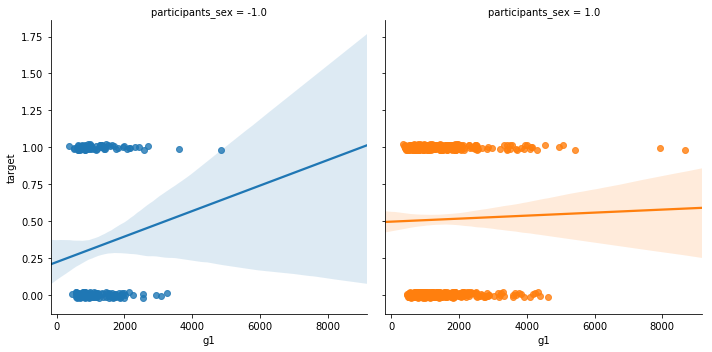

In [95]:
g = sns.lmplot(x="g1", y="target", col="participants_sex", hue="participants_sex", data=data2_train, 
               y_jitter=.02, logistic=False)

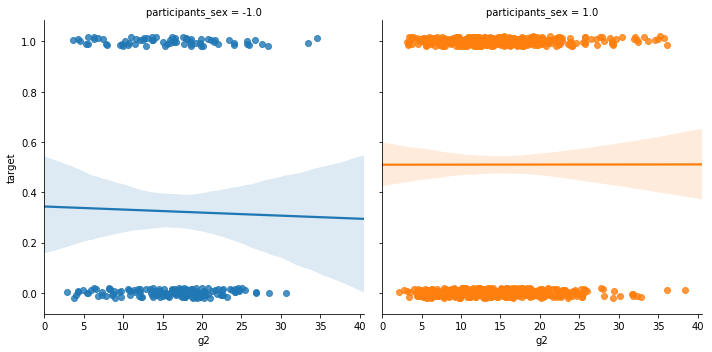

In [96]:
g = sns.lmplot(x="g2", y="target", col="participants_sex", hue="participants_sex", data=data2_train, 
               y_jitter=.02, logistic=False)

In [98]:
results = evaluation(data2_train.loc[:, g1], data2_train.loc[:, 'target'], verbose=True)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.987 +- 0.006
Validation score ROC-AUC: 0.924 +- 0.012 

Training score accuracy: 0.939 +- 0.023
Validation score accuracy: 0.837 +- 0.019


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.6s finished


In [99]:
results = evaluation(data2_train.loc[:, g2], data2_train.loc[:, 'target'], verbose=False)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.999 +- 0.001
Validation score ROC-AUC: 0.963 +- 0.011 

Training score accuracy: 0.981 +- 0.012
Validation score accuracy: 0.890 +- 0.016


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.0s finished


In [100]:
results = original_evaluation(data2_train.loc[:, g2], data2_train.loc[:, 'target'], verbose=False)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.998 +- 0.000
Validation score ROC-AUC: 0.976 +- 0.006 

Training score accuracy: 0.976 +- 0.003
Validation score accuracy: 0.912 +- 0.010


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    8.0s finished


In [101]:
print("[", end="")
for f in g2:
    print("\"{}\"".format(f), end=", ")
print("]")

["power_1011 / participants_age", "power_10121 / participants_age", "power_10132 / participants_age", "power_10157 / participants_age", "power_10182 / participants_age", "power_10189 / participants_age", "power_10220 / participants_age", "power_10222 / participants_age", "power_10251 / participants_age", "power_1027 / participants_age", "power_1028 / participants_age", "power_10375 / participants_age", "power_1043 / participants_age", "power_10444 / participants_age", "power_1045 / participants_age", "power_10457 / participants_age", "power_10463 / participants_age", "power_10515 / participants_age", "power_10589 / participants_age", "power_10654 / participants_age", "power_10660 / participants_age", "power_10717 / participants_age", "power_10721 / participants_age", "power_10723 / participants_age", "power_1075 / participants_age", "power_10880 / participants_age", "power_10882 / participants_age", "power_1094 / participants_age", "power_10951 / participants_age", "power_10953 / parti

PCA on covariance vector connectome

In [43]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
pca.fit(x_train)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [44]:
pca_x_train = pca.transform(x_train)

In [55]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold


seed = 90
       

class FeatureExtractor(BaseEstimator, TransformerMixin):
        
    def __init__(self):
        self.pca = PCA(n_components=70)
        
    def fit(self, X_df, y):
        self.pca.fit(X_df)
        return self

    def transform(self, X_df):
        # get only the anatomical information
        return self.pca.transform(X_df)
    

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(
                                StandardScaler(),
                                LogisticRegressionCV(n_jobs=8,
                                                     # cv=StratifiedKFold(n_splits=5, random_state=seed),                                                    
                                                     scoring="roc_auc", 
                                                     random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(
                                 StandardScaler(),
                                 LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

In [56]:
results = evaluation(x_train, data1_train['target'], verbose=True)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.824 +- 0.018
Validation score ROC-AUC: 0.697 +- 0.013 

Training score accuracy: 0.746 +- 0.019
Validation score accuracy: 0.639 +- 0.019


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.2s finished


PCA 90
```
Training score ROC-AUC: 0.853 +- 0.012
Validation score ROC-AUC: 0.703 +- 0.015 

Training score accuracy: 0.777 +- 0.012
Validation score accuracy: 0.648 +- 0.011
```



PCA on vector tangent connectome

In [69]:
# Precompute features
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA

from nilearn.signal import clean
from nilearn.connectome import ConnectivityMeasure


fmri_motions_filenames = data1_train['fmri_motions']        
fmri_power_filenames = data1_train['fmri_power_2011']

all_confounds = [np.loadtxt(os.path.join(path, path_motions)) 
                 for path_motions in fmri_motions_filenames]

all_timeseries = [pd.read_csv(os.path.join(path, subject_filename), header=None).values 
                  for subject_filename in fmri_power_filenames]

all_cleaned_timeseries = [clean(ts, confounds=cf) for ts, cf in zip(all_timeseries, all_confounds)]
all_cleaned_timeseries = np.array(all_cleaned_timeseries)

In [70]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA

from nilearn.signal import clean
from nilearn.connectome import ConnectivityMeasure


class FeatureExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        # make a transformer which will load the time series and compute the connectome matrix
        self.transformer_fmri = make_pipeline(
            ConnectivityMeasure(kind='tangent', vectorize=True),
            PCA(n_components=100)
        )
        
    def fit(self, X_df, y):
        self.transformer_fmri.fit(X_df)
        return self

    def transform(self, X_df):
        return self.transformer_fmri.transform(X_df)
    
    
class Classifier(BaseEstimator):
    
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(
                                StandardScaler(),
                                LogisticRegressionCV(n_jobs=8,
                                                     # cv=StratifiedKFold(n_splits=5, random_state=seed),                                                    
                                                     scoring="roc_auc", 
                                                     random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(
                                 StandardScaler(),
                                 LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)    

In [71]:
results = evaluation(all_cleaned_timeseries, data1_train['target'], verbose=True)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.844 +- 0.012
Validation score ROC-AUC: 0.689 +- 0.025 

Training score accuracy: 0.753 +- 0.016
Validation score accuracy: 0.633 +- 0.016


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 26.5min finished
